# 1. Data Processing

## 1.1. Raw Data

In [50]:
# Import the libraries 
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from time import time
from ortools.sat.python import cp_model
from ortools.linear_solver import pywraplp

In [6]:
# Read Data 
def input_data(file):
    with open(file, 'r') as file:
        # read first line 
        N, D, a, b = [int(x) for x in file.readline().split()] 

        # Matrix (n,d) full 0, if staff i rest day d(i) -> convert to 1 
        F = np.full((N, D), 0)  
        for staff in range(N):
            # read each line to end, [:-1] bcs end of each line is -1 
            temp = [int(x) for x in file.readline().split()[:-1]]  #check each line from 2 -> i+1
            for day in temp:
                F[staff, day-1] = 1 # day-1 bcs index of list
    return N, D, a, b, F

# Input 
N, D, a, b, F = input_data("data.txt")

In [7]:
# Check status to apply color for each type of status
def status_color(value):
  if value == "Rest": 
    color = 'Green'
  elif value == "Nigh":
    color = 'Red'
  else:
    color = 'White'
  return 'background-color: %s' % color

## 1.2. Data Generations

In [8]:
N, D, a, b, F = input_data("data.txt")

# 2. CSOP

## 2.1 Optimization

In [9]:
# Declare the Model 
model = cp_model.CpModel()

# Create the Variables
# X[staff, day, shift] = 1 if staff i work on shift k of day j 
# X[staff, day, shift] = 0, otw
X = {} 
for staff in range(N):              # check each staff 
    for day in range(D):            # check each staff
        for shift in range(1,5):    # check each shift
            X[staff, day, shift] = model.NewIntVar(0,1,"X[{},{},{}]".format(staff,day,shift))

In [10]:
# Each day, a staff can only work one shift at most
for staff in range(N):    
    for day in range(D):   
        if F[staff, day] == 0:
            if day == 0:
                model.Add(sum([X[staff, day, shift] for shift in range(1,5)]) == 1)
            # If you work the night shift the day before, you can rest the next day
            else:
                model.Add(sum([X[staff, day, shift] for shift in range(1,5)]) + X[staff, day - 1, 4] == 1)
        else: # F[staff, day] == 1
            model.Add(sum([X[staff, day, shift] for shift in range(1,5)]) == 0)

In [11]:
# Each shift in each day has at least [a] staffs and at most [b] staffs
for day in range(D):               
    for shift in range(1,5):    
        model.Add(sum([X[staff, day, shift] for staff in range(N)]) >= a)
        model.Add(sum([X[staff, day, shift] for staff in range(N)]) <= b)

In [12]:
# F(i): list of staff rest days i
# The maximum number of night shifts assigned to a specific staff is the smallest

max_night_shift = model.NewIntVar(1, int(D/2) + 1, 'max_night_shift') 
# for loop add constraint confirm sum of all night shift of staff <= max_night_shift
for staff in range(N):
    model.Add(sum([X[staff, day, 4] for day in range(D)]) - max_night_shift <= 0)

In [13]:
# Objective Function
model.Minimize(max_night_shift)

# Solver
solver = cp_model.CpSolver()
status = solver.Solve(model)
if __name__ == '__main__':
  if status == cp_model.OPTIMAL:
    print("Optimal Value:", int(solver.ObjectiveValue()))
    for staff in range(N):
        for day in range(D):
            for shift in range(1, 5):
              if int(solver.Value(X[staff, day, shift])) == 1:
                print(f'Staff {staff+1} works on day {day+1}, at shift {shift}')
  else: 
    print("No Optimal Solution!")

Optimal Value: 1
Staff 1 works on day 1, at shift 1
Staff 1 works on day 2, at shift 4
Staff 1 works on day 4, at shift 3
Staff 1 works on day 5, at shift 2
Staff 2 works on day 1, at shift 2
Staff 2 works on day 2, at shift 2
Staff 2 works on day 3, at shift 1
Staff 2 works on day 5, at shift 4
Staff 3 works on day 1, at shift 3
Staff 3 works on day 2, at shift 1
Staff 3 works on day 3, at shift 2
Staff 3 works on day 4, at shift 1
Staff 3 works on day 5, at shift 2
Staff 4 works on day 1, at shift 1
Staff 4 works on day 2, at shift 1
Staff 4 works on day 3, at shift 1
Staff 4 works on day 4, at shift 4
Staff 5 works on day 1, at shift 1
Staff 5 works on day 2, at shift 3
Staff 5 works on day 3, at shift 4
Staff 5 works on day 5, at shift 2
Staff 6 works on day 1, at shift 3
Staff 6 works on day 2, at shift 3
Staff 6 works on day 3, at shift 4
Staff 6 works on day 5, at shift 3
Staff 7 works on day 1, at shift 4
Staff 7 works on day 3, at shift 1
Staff 7 works on day 4, at shift 2
Sta

## 2.2. Visualization

In [14]:
# Matrix (n,d,s=5) full 0, if staff i works day j, shift k -> 1 add to matrix; 0 otw
# S is work calendar of each staff, day is column & 5 is shift
S = np.full((N, D, 5), 0)

for staff in range(N):
    for day in range(D):
        for shift in range(1,5):
            S[staff, day, shift] = int(solver.Value(X[staff, day, shift])) # return {0;1}

# Label days & Shift to visualize
days = np.array([f"Day {day}" for day in range(1,D+1)])
shifts = np.array(["Morning", "Noon", "Afternoon", "Night"])

# Flat S by axis 0, use sum to return matrix include sum staff for each shift day
staff_per_shift = np.sum(S, axis=0)
# Create pandas DF to visualize
df_staff_shift = pd.DataFrame(data=staff_per_shift[:, 1:].T, index=shifts, columns=days)

# Visualize number staffs for each shift of day
df_staff_shift.style.background_gradient(cmap='Pastel2')

,Day 1,Day 2,Day 3,Day 4,Day 5
Morning,3,2,3,2,1
Noon,1,2,2,1,3
Afternoon,3,2,1,2,2
Night,2,1,2,1,1


In [15]:
col = np.array([f"Staff {staff}" for staff in range(1,N+1)])
row = days
details = np.full((D,N),"Rest")

for day in range(D):
  for staff in range(N):
    for shift in range(1,5):
      if S[staff, day, shift] == 1:
        details[day,staff] = shifts[shift-1]
        break

# Visualize details shift for each staff
pf_details = pd.DataFrame(data = details, index = row, columns = col)  
pf_details.style.applymap(status_color)

,Staff 1,Staff 2,Staff 3,Staff 4,Staff 5,Staff 6,Staff 7,Staff 8,Staff 9
Day 1,Morn,Noon,Afte,Morn,Morn,Afte,Nigh,Nigh,Afte
Day 2,Nigh,Noon,Morn,Morn,Afte,Afte,Rest,Rest,Noon
Day 3,Rest,Morn,Noon,Morn,Nigh,Nigh,Morn,Afte,Noon
Day 4,Afte,Rest,Morn,Nigh,Rest,Rest,Noon,Afte,Morn
Day 5,Noon,Nigh,Noon,Rest,Noon,Afte,Morn,Rest,Afte


# 3. IP

## 3.1. Optimization

In [16]:
solver = pywraplp.Solver('ROSTERING_MIP', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
INF = solver.infinity()

# DECISION VARIABLES
x = {}
for i in range(N):
    for j in range(D):
        for k in range(1, 5):
            x[i, j, k] = solver.IntVar(0, 1, f'x[{i}, {j}, {k}]')

z = solver.IntVar(0, D, 'z')  # z is an auxiliary variable to facilitate the objective function

In [17]:
# CONSTRAINTS
# Each employee works no more than one shift every day
for i in range(N):
    for j in range(D):
        if F[i][j] == 0:
            cstr = solver.Constraint(-INF, 1)
            for k in range(1, 5):
                cstr.SetCoefficient(x[i, j, k], 1)
            if j != 0:
                cstr.SetCoefficient(x[i, j-1, 4], 1)

In [18]:
# Employees can have a day off after having a night shift on the previous day
for i in range(N):
    for j in range(D):
        if F[i][j] == 0:
            cstr = solver.Constraint(1, 1)
            for k in range(1, 5):
                cstr.SetCoefficient(x[i, j, k], 1)
                if j != 0:
                    cstr.SetCoefficient(x[i, j-1, 4], 1)

In [19]:
# Employees will not work on their off days
for i in range(N):
    for j in range(D):
        if F[i][j] == 1:
            cstr = solver.Constraint(0, 0)
            for k in range(1, 5):
                cstr.SetCoefficient(x[i, j, k], 1)

In [20]:
# Each shift have at least alpha and beta employees at most
for j in range(D):
    for k in range(1, 5):
        cstr = solver.Constraint(a, b)
        for i in range(N):
            cstr.SetCoefficient(x[i, j, k], 1)

In [21]:
# OBJECTIVE FUNCTION
for i in range(N):  # the maximum night shift of any employee is minimize
    obj = solver.Constraint(0, INF)
    for j in range(D):
        obj.SetCoefficient(x[i, j, 4], -1)
        obj.SetCoefficient(z, 1)

In [22]:
solver.Minimize(z)
status = solver.Solve()

if __name__ == '__main__':
    if status == pywraplp.Solver.OPTIMAL:
        print('Optimal value:', solver.Objective().Value())
        for i in range(N):
            for j in range(D):
                for k in range(1, 5):
                    if x[i, j, k].solution_value() > 0:
                        print(f'Employee {i+1} works on day {j+1}, at shift {k}')
    else:
        print("No optimal solution!")

Optimal value: 1.0
Employee 1 works on day 1, at shift 2
Employee 1 works on day 2, at shift 2
Employee 1 works on day 3, at shift 2
Employee 1 works on day 4, at shift 2
Employee 1 works on day 5, at shift 1
Employee 2 works on day 1, at shift 4
Employee 2 works on day 3, at shift 3
Employee 2 works on day 5, at shift 3
Employee 3 works on day 1, at shift 3
Employee 3 works on day 2, at shift 3
Employee 3 works on day 3, at shift 1
Employee 3 works on day 4, at shift 3
Employee 3 works on day 5, at shift 2
Employee 4 works on day 1, at shift 1
Employee 4 works on day 2, at shift 3
Employee 4 works on day 3, at shift 2
Employee 4 works on day 4, at shift 3
Employee 4 works on day 5, at shift 4
Employee 5 works on day 1, at shift 2
Employee 5 works on day 2, at shift 1
Employee 5 works on day 3, at shift 4
Employee 5 works on day 5, at shift 1
Employee 6 works on day 1, at shift 2
Employee 6 works on day 2, at shift 1
Employee 6 works on day 3, at shift 3
Employee 6 works on day 4, at s

## 3.2. Visualization

In [23]:
# Create S to store day rest of each staff
# Definite shift > 0, so create S(N,D,5) with first col useless
S = np.full((N, D, 5), 0)

for staff in range(N):
    for day in range(D):
        for shift in range(1,5):
            # add value to matrix S full 0 
            S[staff, day, shift] = int(x[staff, day, shift].solution_value())

shifts = np.array(["Morning", "Noon", "Afternoon", "Night"])
days = np.array([f"Day {day}" for day in range(1,D+1)])
day_shifts = np.sum(S, axis=0)
day_shifts_solution = pd.DataFrame(data=day_shifts[:, 1:].T, index=shifts, columns=days)

# Visualize number staffs for each shift of day
day_shifts_solution.style.background_gradient(cmap='Pastel1')

,Day 1,Day 2,Day 3,Day 4,Day 5
Morning,3,2,2,1,2
Noon,3,2,3,2,2
Afternoon,2,3,2,3,3
Night,1,1,1,1,1


In [24]:
col = np.array([f"Staff {staff}" for staff in range(1,N+1)])
row = days
details_ip = np.full((D,N),"Rest")

for r in range(D):
  for c in range(N):
    for shift in range(1,5):
      if S[c,r,shift] == 1:
        details_ip[r,c] = shifts[shift-1]
        break

# Visualize details shift for each staff
pf_details_ip = pd.DataFrame(data = details_ip, index = row, columns = col)
pf_details_ip.style.applymap(status_color)

,Staff 1,Staff 2,Staff 3,Staff 4,Staff 5,Staff 6,Staff 7,Staff 8,Staff 9
Day 1,Noon,Nigh,Afte,Morn,Noon,Noon,Morn,Afte,Morn
Day 2,Noon,Rest,Afte,Afte,Morn,Morn,Nigh,Afte,Noon
Day 3,Noon,Afte,Morn,Noon,Nigh,Afte,Rest,Morn,Noon
Day 4,Noon,Rest,Afte,Afte,Rest,Afte,Noon,Nigh,Morn
Day 5,Morn,Afte,Noon,Nigh,Morn,Afte,Noon,Rest,Afte


# 4. Heuristics

## 4.1. Optimization

**Idea**: For each day, we will assign employees to the night shift such that all the conditions are satisfied, and also
incurs the smallest number of night shifts of employees (thus still optimising the total number of night shifts).


Concretely, we will prioritise employees with minimal number of current night shifts and employees that have off days
on the next day.

In [25]:
# Convert F to satisfy heuristics
F = np.array(F)
F = np.pad(F, ((0,0),(0,1)), mode='constant', constant_values=0)  # add another column of 0s for easier index

In [26]:
def select(N, off_today, off_nextday, a, b):
    '''
    :param off_today: number of employees cannot work today
    :param off_nextday: number of employees cannot work on the next day
    :return: z = minimum value of the night shift of an employee
    :return: add = number of employees need to add to suffice the bound
    '''
    z, add = 0, 0
    # z is number of staff work night shift today
    # add is number of staff need add for enough limit staff
    upper_today = N - off_today - 4*a  # upper bound of the number of employees working in a shift today
    lower_today = N - off_today - 4*b
    # số nhân viên min cần có trong một ca của ngày hôm NAY: tổng nhân viên - số nhân viên không đi làm hôm nay - cận dưới của một ca (có 4 ca nên nhân 4)
    # số nhân viên max cần có trong một ca của ngày hôm NAY: tổng nhân viên - số nhân viên không đi làm hôm nay - cận trên của một ca

    if upper_today < a or lower_today > b:
        return -1
    else:
        z = max(lower_today, a)  # giả sử z (số ca đêm hNAY) nhận giá trị ban đầu chính bằng cận dưới (việc này sẽ đảm bảo được rằng số ca đêm là ít nhất, vì nó chính bằng cận dưới)
        # lower_today có thể nhận giá trị âm, vì vậy lấy max để đảm bảo giới hạn phải là dương


    upper_nextday = N - off_nextday - z - 4*a  # vì có z nhân viên làm ca đêm hôm NAY rồi, nên hôm SAU có z nhân viên được nghỉ
    lower_nextday = N - off_nextday - z - 4*b

    if lower_nextday > b:  # nếu lower bound của ngày hôm sau lớn hơn b (giới hạn của đề bài) thì cắt bớt cho phù hợp
        z += (lower_nextday - b)
    elif upper_nextday < a:  # ngược lại, thấp hơn thì mình cần bổ sung
        add = a - upper_nextday  # add employees to suffice the bound
    else:  # đã đủ nhân viên
        add = 0

    if z > b or z < a or add > off_nextday:  # kiểm tra điều kiện tồn tại nghiệm
        return -1
    else:
        return z, add


In [27]:
def heuristics(N, D, a, b, F):
    num_night = np.full(N, 0)  # number of night shifts of each employee
    global x  # matrix solution

    for j in range(D):
        off_today = np.array(F[:, j][:N])  # binary list, cho biết nhân viên nào đi làm và nghỉ làm hôm NAY
        # ví dụ: [0 0 0 1] tức là nhân viên cuối hôm nay  nghỉ (=1 là nghỉ)
        #print(off_today)
        off_nextday = np.array(F[:, j+1][:N])  # tương tự, nhưng của hôm SAU

        if j != 0:  # nhân viên nào làm ca đêm hôm NAY thì sẽ được chuyển vào danh sách nghỉ của ngày hôm SAU
            for i in range(N):
                if x[i, j-1, 3] == 1:  # if employee i worked at the night shift on the previous day, then rest today
                    off_today[i] = 1

        # Select the possible minimum number of night shift
        if select(N, sum(off_today), sum(off_nextday), a, b) is False:
            print('No optimal solution found.')
            return -1
        else:
            z, add = select(N, sum(off_today), sum(off_nextday), a, b)
        remain = z - add

        # Assign the employee with minimum number of night shift (and absent on the next day) to today's night shift
        emp_off_nextday = np.array([i for i in range(len(off_nextday)) if off_nextday[i] == 1]) # chỉ số các nv nghỉ hsau
        # ví dụ: [4] -> hôm sau chỉ có nhân viên số 4 nghỉ
        off_night_nextday = np.array([num_night[i] for i in emp_off_nextday])
        # trong số các nhân viên nghỉ vào ngày hôm sau, trích ra số ca đêm của nhân viên đó

        while add > 0:
            emp_index = np.argmin(off_night_nextday)  # lựa chọn ra nhân viên có số ca đêm ít nhất hiện tại
            x[emp_off_nextday[emp_index], j, 3] = 1  # cho đi làm ca đêm
            num_night[emp_off_nextday[emp_index]] += 1  # add 1 employee to today's night shift
            # sau khi gán xong, mình phải đặt nhân viên này sang trạng thái nghỉ hnay
            off_today[emp_off_nextday[emp_index]] = 1  # avoid working more than one shift in a day
            add -= 1

        # Assign other employees to the night shift if needed (choose among idle employees for today)
        emp_work_today = np.array([i for i in range(len(off_today)) if off_today[i] != 1]) # = 0 : hnay đi làm được
        work_night_today = np.array([num_night[i] for i in emp_work_today])  # số ca đêm của các nhân viên đi làm vào hNAY


        while remain > 0:  # tương tự hàm trên
            emp_index = np.argmin(work_night_today)
            x[emp_work_today[emp_index], j, 3] = 1
            num_night[emp_work_today[emp_index]] += 1
            off_today[emp_work_today[emp_index]] = 1
            remain -= 1

        # Assign other employees to other shifts of today
        i, k = 0, 0  # gán những nhân viên còn lại vào các ca sáng, trưa, và chiều
        while i < N and k < 3:
            if off_today[i] == 0:
                x[i, j, k] = 1
                off_today[i] = 1  # avoid assigning the same employee in a day
                k = (k+1) % 3
            i += 1
    return max(num_night)

In [28]:
if __name__ == '__main__':
    x = np.full((N, D, 4), 0)  # solution matrix

    start = time()
    res = heuristics(N, D, a, b, F)
    end = time()
    print('The optimal value is:', res)
    print('The optimal solution is:')

    for i in range(N):
        for j in range(D):
            for k in range(4):
                if x[i, j, k] == 1:
                    print(f'Employee {i+1}: works on day {j+1}, at shift {k+1}')

    # print(x)
    print('Total execution time:', end-start)

The optimal value is: 1
The optimal solution is:
Employee 1: works on day 1, at shift 4
Employee 1: works on day 3, at shift 1
Employee 1: works on day 4, at shift 1
Employee 1: works on day 5, at shift 1
Employee 2: works on day 1, at shift 1
Employee 2: works on day 2, at shift 4
Employee 2: works on day 5, at shift 2
Employee 3: works on day 1, at shift 2
Employee 3: works on day 2, at shift 1
Employee 3: works on day 3, at shift 4
Employee 3: works on day 5, at shift 3
Employee 4: works on day 1, at shift 3
Employee 4: works on day 2, at shift 2
Employee 4: works on day 3, at shift 2
Employee 4: works on day 4, at shift 4
Employee 5: works on day 1, at shift 1
Employee 5: works on day 2, at shift 3
Employee 5: works on day 3, at shift 3
Employee 5: works on day 4, at shift 2
Employee 5: works on day 5, at shift 4
Employee 6: works on day 1, at shift 2
Employee 6: works on day 2, at shift 1
Employee 6: works on day 3, at shift 1
Employee 6: works on day 4, at shift 3
Employee 6: wor

## 4.2. Visualization

In [29]:
# column 5th is useless
S = np.full((N, D, 5), 0)

for staff in range(N):
    for day in range(D):
        for shift in range(4):
            S[staff, day, shift] = int(x[staff, day, shift])

shifts = np.array(["Morning", "Noon", "Afternoon", "Night"])
days = np.array([f"Day {day}" for day in range(1,D+1)])
day_shifts = np.sum(S, axis=0)
day_shifts_solution = pd.DataFrame(data=day_shifts[:, :4].T, index=shifts, columns=days)

# Visualize number staffs for each shift of day
day_shifts_solution.style.background_gradient(cmap='Pastel2')

,Day 1,Day 2,Day 3,Day 4,Day 5
Morning,3,3,3,2,2
Noon,3,2,2,2,2
Afternoon,2,2,2,2,2
Night,1,1,1,1,1


In [30]:
col = np.array([f"Staff {staff}" for staff in range(1,N+1)])
row = days
details_heu = np.full((D,N),"Rest")

for r in range(D):
  for c in range(N):
    for shift in range(1,5):
      if S[c,r,shift-1] == 1:
        details_heu[r,c] = shifts[shift-1]
        break

# Visualize details shift for each staff
pf_details_heu = pd.DataFrame(data = details_heu, index = row, columns = col)
pf_details_heu.style.applymap(status_color)

,Staff 1,Staff 2,Staff 3,Staff 4,Staff 5,Staff 6,Staff 7,Staff 8,Staff 9
Day 1,Nigh,Morn,Noon,Afte,Morn,Noon,Afte,Morn,Noon
Day 2,Rest,Nigh,Morn,Noon,Afte,Morn,Noon,Afte,Morn
Day 3,Morn,Rest,Nigh,Noon,Afte,Morn,Noon,Afte,Morn
Day 4,Morn,Rest,Rest,Nigh,Noon,Afte,Morn,Noon,Afte
Day 5,Morn,Noon,Afte,Rest,Nigh,Morn,Noon,Rest,Afte


# 5. Visualization

## 5.1. [30 Days]

In [45]:
# Read data
df_ip_30 = pd.read_csv('running_time/IP_d30.csv', header = None)
df_heu_30 = pd.read_csv('running_time/Heuristics_d30.csv', header = None)
df_csp_30 = pd.read_csv('running_time/CSP_d30.csv', header = None)

In [46]:
# CSOP
df_csp_30.columns = ['N', 'CSOP']
df_csp_30.set_index('N', inplace = True)
df_csp_30['CSOP'] = df_csp_30['CSOP'].apply(np.log)

In [47]:
# IP 
df_ip_30.columns = ['N', 'IP']
df_ip_30.set_index('N', inplace = True)
df_ip_30['IP'] = df_ip_30['IP'].apply(np.log)

In [48]:
# Heuristics
df_heu_30.columns = ['N', 'Heuristics']
df_heu_30.set_index('N', inplace=True)
df_heu_30['Heuristics'] = df_heu_30['Heuristics'].apply(np.log)

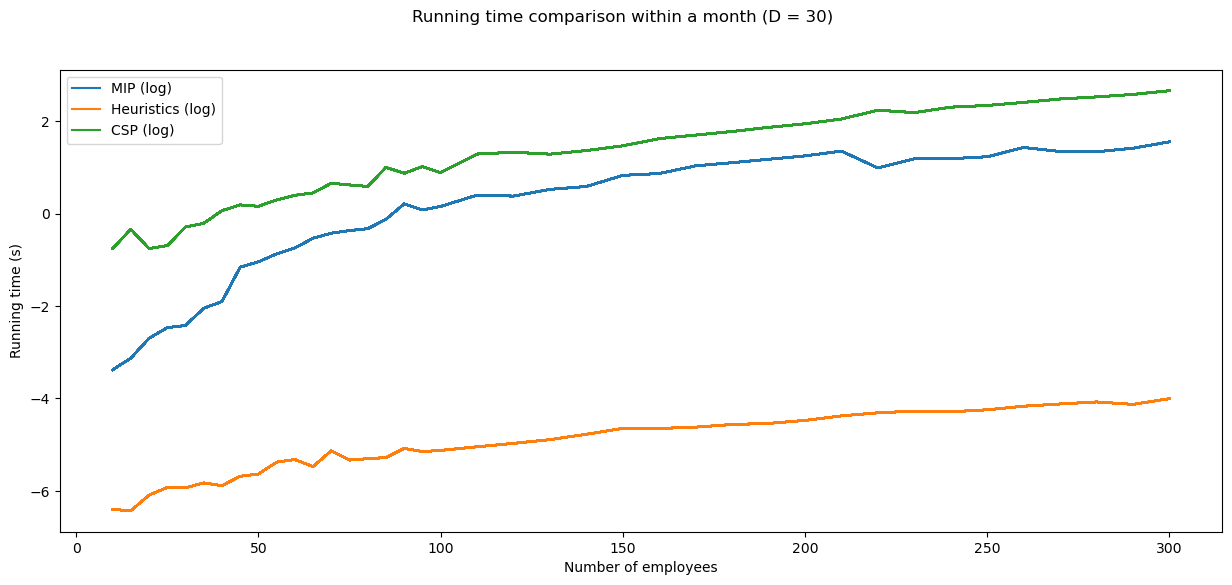

In [58]:
# Visualize
plt.figure(figsize=(15, 6))

plt.plot(df_ip_30.index, df_ip_30['IP'], label='IP (log)')
plt.plot(df_heu_30.index, df_heu_30['Heuristics'], label='Heuristics (log)')
plt.plot(df_csp_30.index, df_csp_30['CSOP'], label='CSP (log)')
plt.legend(loc='upper left')
plt.suptitle('Running time comparison within a month (D = 30)')
plt.xlabel('Number of employees')
plt.ylabel('Running time (s)')
plt.show();

## 5.2. [180 Days]

In [60]:
# Read data
df_ip_180 = pd.read_csv('running_time/IP_d180.csv', header = None)
df_heu_180 = pd.read_csv('running_time/Heuristics_d180.csv', header = None)

In [ ]:
# IP 
df_ip_180.columns = ['N', 'IP']
df_ip_180.set_index('N', inplace = True)
df_ip_180['IP'] = df_ip_180['IP'].apply(np.log)

In [ ]:
# Heuristics
df_heu_180.columns = ['N', 'Heuristics']
df_heu_180.set_index('N', inplace=True)
df_heu_180['Heuristics'] = df_heu_180['Heuristics'].apply(np.log)

In [ ]:
# Visualize
plt.figure(figsize=(15, 6))

plt.plot(df_ip_180.index, df_ip_180['IP'], label='IP (log)')
plt.plot(df_heu_180.index, df_heu_180['Heuristics'], label='Heuristics (log)')
plt.legend(loc='upper left')
plt.suptitle('Running time comparison within 180 days (D = 180)')
plt.xlabel('Number of employees')
plt.ylabel('Running time (s)')

## 5.3. [365 Days]

In [ ]:
# Read Data
df_ip_365 = pd.read_csv('running_time/IP_d365.csv', header=None)
df_heu_365 = pd.read_csv('running_time/Heuristics_d365.csv', header=None)

In [ ]:
# IP
df_ip_365.columns = ['N', 'IP']
df_ip_365.set_index('N', inplace=True)
df_ip_365['IP'] = df_ip_365['IP'].apply(np.log)

In [ ]:
# Heuristics
df_heu_365.columns = ['N', 'Heuristics']
df_heu_365.set_index('N', inplace=True)
df_heu_365['Heuristics'] = df_heu_365['Heuristics'].apply(np.log)

In [ ]:
# Visualize 
plt.figure(figsize=(15, 6))

plt.plot(df_ip_365.index, df_ip_365['IP'], label='IP (log)')
plt.plot(df_heu_365.index, df_heu_365['Heuristics'], label='Heuristics (log)')
plt.legend(loc='upper left')
plt.suptitle('Running time comparison within a year (D = 365)')
plt.xlabel('Number of employees')
plt.ylabel('Running time (s)')
plt.savefig('d365.jpeg')

## 5.4. Heuristics 1000 Days

In [ ]:
# Read Data
df_heu_1000 = pd.read_csv('running_time/Heuristics_d1000.csv', header=None)
df_heu_1000.columns = ['N', 'Heuristics']
df_heu_1000.set_index('N', inplace=True)

In [ ]:
# Visualize
plt.figure(figsize=(15, 6))

plt.plot(df_heu_1000.index, df_heu_1000['Heuristics'])
plt.suptitle('Running time of Heuristics algorithm within 1000 days')
plt.xlabel('Number of employees')
plt.ylabel('Running time (s)')